## ``Causal_sampler`` Demo. 02: 

### Simulation on the synthetic classification and regression task

> Backdoor confounding

Backdoor confounding scenario assumes there is a confounder performing as a common cause of both the cause and the effect variables. 

In this demonstration, we suppose $U$ is the confounder, $Y$ is the cause and $X$ is the effect.

In [1]:
import causal_sampler.pipeline as cs_pipe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

plt.rcParams['font.family'] = 'Calibri'
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.titlesize"] = 14

def linear_decision_boundary(clf, xlim):
    weight = clf.coef_[0]
    bias = clf.intercept_[0]
    k = -weight[0] / weight[1]
    b = -bias / weight[1]
    x = np.linspace(xlim[0], xlim[1], 100)
    decison_boundary = k * x + b
    return decison_boundary

def plot_boundary(ax, X, Y, db, xlim, ylim, plot_title):
    handles = []
    scatter = ax.scatter(x= X[:,0], y = X[:,1], c = Y, s = 10, alpha = 0.4, cmap='coolwarm')
    handles_scatter, labels_scatter = scatter.legend_elements(prop="colors")
    handles += handles_scatter
    ax.set_xlim(xlim[0],xlim[1])
    ax.set_ylim(ylim[0],ylim[1])
    x_ = np.linspace(xlim[0], xlim[1], 100)
    
    true_b = ax.plot([0, 0], [-6, 6], 'k', linewidth=4, label="True boundary")
    confounder = ax.plot([-6,6], [0,0], 'orange', linewidth = 4, label = "Confounder boundary")
    clf_b = ax.plot(x_, db, 'r', linewidth = 4, label= 'Classifier Decision')
    handles += [true_b[0], confounder[0], clf_b[0]]
    ax.set_title(plot_title)
    ax.set_xlabel(r"$X_1$")
    ax.set_ylabel(r"$X_2$")
    return ax, handles

0. Define the backdoor causal graph

In [2]:
causal_graph = '"Backdoor Causal Graph"; \
                Y; X; U; \
                U->Y; \
                U->X; \
                Y->X; '

### Discrete intervention

1. Read the demo. data

In [3]:
testdata_dir = r"../test_data/synthetic_data/frontdoor_discY_contZ_contX_discU/"

X_train_conf = pd.read_csv(testdata_dir + "X_train_conf.csv").values
Y_train_conf = pd.read_csv(testdata_dir + "Y_train_conf.csv").values
U_train_conf = pd.read_csv(testdata_dir + "U_train_conf.csv").values

X_test_unconf = pd.read_csv(testdata_dir + "X_test_unconf.csv").values
Y_test_unconf = pd.read_csv(testdata_dir + "Y_test_unconf.csv").values

X_test_conf = pd.read_csv(testdata_dir + "X_test_conf.csv").values
Y_test_conf = pd.read_csv(testdata_dir + "Y_test_conf.csv").values

2. Assign the key-value pair for each variable and prepare essential parameters

In [4]:
conf_train_data = {"X": X_train_conf, 
                   "Y": Y_train_conf, 
                   "U": U_train_conf}
n_bins = {"Y": [0],
          "U": [0]}
n_samples = 2000

3. Initialize a CW-GMM based deconfounding pipeline and fit a deconfounded SVC

In backdoor case, the causal weight function is:

$w_n = \frac{P(u_n)*K[y_n, y_i]}{P(y_n, u_n)}$,

where $K[.]$ is a kernel function, $y_n$ and $u_n$ are the n-th observed instance for variable $Y$ and $U$, $y_i$ is the interventional value for the cause variable. 

> For discrete $Y$, use the default ``"Kronecker delta"`` as the ``kernel`` in ``.fit()`` method. 

> For continuous $Y$, use the ``"Gaussian"`` as the ``kernel`` in ``.fit()`` method. 

In [ ]:
cwgmm_flow = cs_pipe.CausalGMMSampler(causal_graph=causal_graph,
                                      cause_var_name="Y",
                                      effect_var_name="X",
                                      intv_values = np.unique(Y_train_conf),
                                      data_dict = conf_train_data,
                                      est_method = "histogram",
                                      n_bins = n_bins
                                    )
cwgmm_model = cwgmm_flow.fit(comp_k = 6,
                             max_iter = 500,
                             tol = 1e-6,
                             init_method = "kmeans++",
                             cov_type = "full",
                             cov_reg = 1e-6,
                             min_variance_value = 1e-6,
                             random_seed = None,
                             kernel = "Kronecker delta",
                             verbose = 2,
                             return_model = True)
deconf_cwgmm_X, deconf_cwgmm_Y = cwgmm_flow.resample(n_samples = n_samples,
                                                     shuffle = True,
                                                     return_samples = True,
                                                     random_seed = None)
deconf_gmm_clf = cwgmm_flow.fit_deconf_model(ml_model = svm.SVC(kernel = 'linear', C=5))

CW-GMMs fitting:   0%|          | 0/2 [00:00<?, ?model/s]

EM iter:   0%|          | 0/500 [00:00<?, ?it/s]

EM iter:   0%|          | 0/500 [00:00<?, ?it/s]

4. Initialize a causal bootstrapping based deconfounding pipeline and fit a deconfounded SVC

In [6]:
cb_flow = cs_pipe.CausalBootstrapSampler(causal_graph=causal_graph,
                                          cause_var_name="Y",
                                          effect_var_name="X",
                                          intv_values = np.unique(Y_train_conf),
                                          data_dict = conf_train_data,
                                          est_method = "histogram",
                                          n_bins = n_bins)
cb_flow.fit(kernel = "Kronecker delta")
deconf_cb_X, deconf_cb_Y = cb_flow.resample(n_samples = n_samples,
                                            sampling_mode = "fast",
                                            shuffle = True,
                                            return_samples = True,
                                            random_seed = None,
                                            verbose = 1)
deconf_cb_clf = cb_flow.fit_deconf_model(ml_model = svm.SVC(kernel = 'linear', C=5))

CB Resampling:   0%|          | 0/2 [00:00<?, ?it/s]

5. Train another two linear Support Vector Classifiers (SVC) using the original confounded dataset and the non-confounded (test) dataset.

In [7]:
## Train two linear support vector machines using confounded and de-confounded datasets
conf_clf = svm.SVC(kernel = 'linear', C=5)
conf_clf.fit(X_train_conf, Y_train_conf.reshape(-1))

nonconf_clf = svm.SVC(kernel = 'linear', C=5)
nonconf_clf.fit(X_test_unconf, Y_test_unconf.reshape(-1))

SVC(C=5, kernel='linear')

6. compare thier performance on non-confounded and confounded test set

In [8]:
print("Test on the non-confounded test set:")

y_pred_gmm_deconf_unconf = deconf_gmm_clf.predict(X_test_unconf)
print("Report of CW-GMM based deconfounded model:")
print(classification_report(Y_test_unconf, y_pred_gmm_deconf_unconf, digits=4))
print("-"*20)
y_pred_cb_deconf_unconf = deconf_cb_clf.predict(X_test_unconf)
print("Report of CB-based deconfounded model:")
print(classification_report(Y_test_unconf, y_pred_cb_deconf_unconf, digits=4))
print("-"*20)
y_pred_unconf_unconf = nonconf_clf.predict(X_test_unconf)
print("Report of non-confounded model:")
print(classification_report(Y_test_unconf, y_pred_unconf_unconf, digits=4))
print("-"*20)
y_pred_conf_unconf = conf_clf.predict(X_test_unconf)
print("Report of confonded model:")
print(classification_report(Y_test_unconf, y_pred_conf_unconf, digits=4))

Test on the non-confounded test set:
Report of CW-GMM based deconfounded model:
              precision    recall  f1-score   support

           1     0.7667    0.8536    0.8078       362
           2     0.9112    0.8527    0.8810       638

    accuracy                         0.8530      1000
   macro avg     0.8390    0.8531    0.8444      1000
weighted avg     0.8589    0.8530    0.8545      1000

--------------------
Report of CB-based deconfounded model:
              precision    recall  f1-score   support

           1     0.7524    0.8564    0.8010       362
           2     0.9116    0.8401    0.8744       638

    accuracy                         0.8460      1000
   macro avg     0.8320    0.8482    0.8377      1000
weighted avg     0.8540    0.8460    0.8478      1000

--------------------
Report of non-confounded model:
              precision    recall  f1-score   support

           1     0.7836    0.8204    0.8016       362
           2     0.8953    0.8715    0.8832 

In [9]:
print("Test on the confounded test set:")

y_pred_gmm_deconf_conf = deconf_gmm_clf.predict(X_test_conf)
print("Report of deconfounded model using mechanism learning:")
print(classification_report(Y_test_conf, y_pred_gmm_deconf_conf, digits=4))
print("-"*20)
y_pred_cb_deconf_conf = deconf_cb_clf.predict(X_test_conf)
print("Report of deconfounded model using CB-based method:")
print(classification_report(Y_test_conf, y_pred_cb_deconf_conf, digits=4))
print("-"*20)
y_pred_unconf_conf = nonconf_clf.predict(X_test_conf)
print("Report of non-confounded model:")
print(classification_report(Y_test_conf, y_pred_unconf_conf, digits=4))
print("-"*20)
y_pred_conf_conf = conf_clf.predict(X_test_conf)
print("Report of confounded model:")
print(classification_report(Y_test_conf, y_pred_conf_conf, digits=4))

Test on the confounded test set:
Report of deconfounded model using mechanism learning:
              precision    recall  f1-score   support

           1     0.9195    0.8497    0.8832       632
           2     0.7716    0.8723    0.8189       368

    accuracy                         0.8580      1000
   macro avg     0.8456    0.8610    0.8511      1000
weighted avg     0.8651    0.8580    0.8595      1000

--------------------
Report of deconfounded model using CB-based method:
              precision    recall  f1-score   support

           1     0.9185    0.8560    0.8862       632
           2     0.7786    0.8696    0.8216       368

    accuracy                         0.8610      1000
   macro avg     0.8485    0.8628    0.8539      1000
weighted avg     0.8670    0.8610    0.8624      1000

--------------------
Report of non-confounded model:
              precision    recall  f1-score   support

           1     0.9295    0.8133    0.8675       632
           2     0.7360

7. Draw the decision boundaries for the four SVCs and datasets

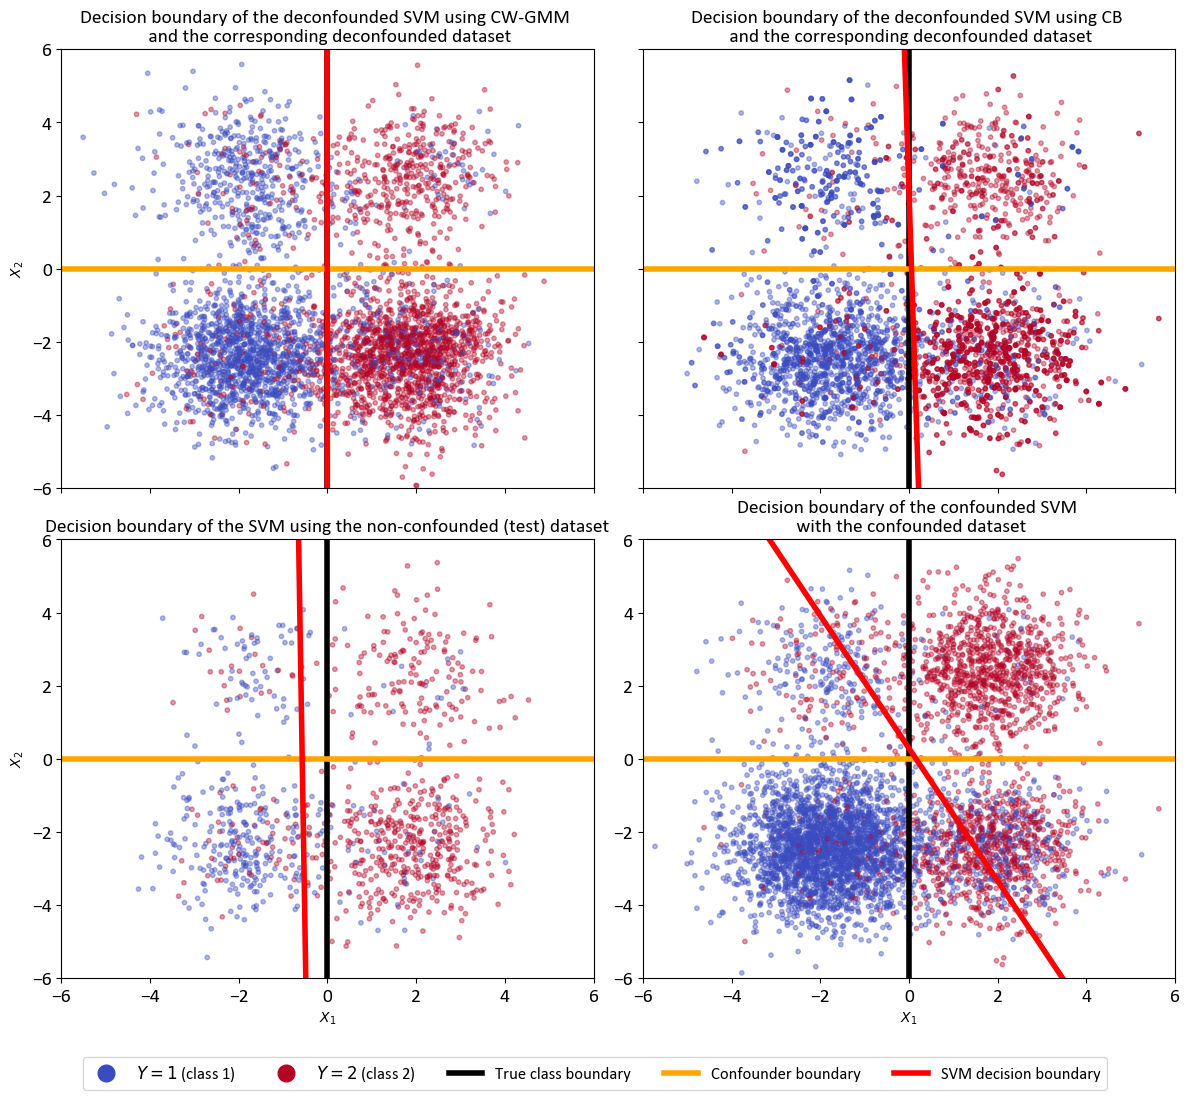

In [10]:
# Compute the decision boundary of the two models
decision_boundary_deconf_cwgmm = linear_decision_boundary(clf = deconf_gmm_clf, xlim = [-4,4])
decision_boundary_deconf_cb = linear_decision_boundary(clf = deconf_cb_clf, xlim = [-4,4])
decision_boundary_unconf = linear_decision_boundary(clf = nonconf_clf, xlim = [-4,4])
decision_boundary_conf = linear_decision_boundary(clf = conf_clf, xlim = [-4,4])

fig, axes = plt.subplots(2,2, figsize = (12,12))
axes_flatten = axes.ravel()
axes_flatten[0], _ = plot_boundary(axes_flatten[0], deconf_cwgmm_X, deconf_cwgmm_Y, 
                        decision_boundary_deconf_cwgmm, [-6,6], [-6,6], 'Decision boundary of the deconfounded SVM using CW-GMM \n and the corresponding deconfounded dataset')
axes_flatten[1], _ = plot_boundary(axes_flatten[1], deconf_cb_X, deconf_cb_Y,
                        decision_boundary_deconf_cb, [-6,6], [-6,6], 'Decision boundary of the deconfounded SVM using CB \n and the corresponding deconfounded dataset')
axes_flatten[2], _ = plot_boundary(axes_flatten[2], X_test_unconf, Y_test_unconf,
                        decision_boundary_unconf, [-6,6], [-6,6], 'Decision boundary of the SVM using the non-confounded (test) dataset')
axes_flatten[3], handles = plot_boundary(axes_flatten[3], X_train_conf, Y_train_conf, 
                        decision_boundary_conf, [-6,6], [-6,6], 'Decision boundary of the confounded SVM \n with the confounded dataset')
axes_flatten[0].tick_params(labelbottom=False)
axes_flatten[0].set_xlabel('')  
axes_flatten[1].tick_params(labelbottom=False, labelleft=False)
axes_flatten[1].set_xlabel('')  
axes_flatten[1].set_ylabel('')
axes_flatten[3].set_ylabel('')
labels = [r'$Y=1$ (class 1)', r'$Y=2$ (class 2)',
          'True class boundary', 'Confounder boundary', 'SVM decision boundary']
legend =fig.legend(handles=handles,
                   labels=labels,
                   loc='lower center',
                   bbox_to_anchor=(0.5, 0.08),
                   ncol=5,
                   markerscale=2)
for handle in legend.legend_handles:
    handle.set_alpha(1.0)
plt.tight_layout()
plt.subplots_adjust(bottom=0.18)
plt.show()


#### Continous intervention

1. Read the demo. data

In [11]:
testdata_dir = r"../test_data/synthetic_data/frontdoor_contY_contZ_contX_contU/"
X_train_conf = pd.read_csv(testdata_dir + "X_train_conf.csv").values
Y_train_conf = pd.read_csv(testdata_dir + "Y_train_conf.csv").values
U_train_conf = pd.read_csv(testdata_dir + "U_train_conf.csv").values

X_test_unconf = pd.read_csv(testdata_dir + "X_test_unconf.csv").values
Y_test_unconf = pd.read_csv(testdata_dir + "Y_test_unconf.csv").values

X_test_conf = pd.read_csv(testdata_dir + "X_test_conf.csv").values
Y_test_conf = pd.read_csv(testdata_dir + "Y_test_conf.csv").values


2. Assign the key-value pair for each variable and prepare essential parameters

In [12]:
conf_train_data = {"X": X_train_conf, 
                   "Y": Y_train_conf, 
                   "U": U_train_conf}


In [13]:
intv_intval_num = 100
N = X_train_conf.shape[0]
Y_interv_values = np.linspace(np.mean(Y_train_conf) - 1.05*(np.max(Y_train_conf)- np.min(Y_train_conf)), 
                              np.mean(Y_train_conf) + 1.05*(np.max(Y_train_conf)- np.min(Y_train_conf)), 
                              intv_intval_num)
n_samples = [int(N/intv_intval_num)]*intv_intval_num

3. Initialize a **CW-GMM** based deconfounding pipeline

In [14]:
cwgmm_flow = cs_pipe.CausalGMMSampler(causal_graph=causal_graph,
                                      cause_var_name="Y",
                                      effect_var_name="X",
                                      intv_values = Y_interv_values,
                                      data_dict = conf_train_data,
                                      est_method = "multinorm"
                                    )
cwgmm_model = cwgmm_flow.fit(comp_k = 2,
                             max_iter = 1000,
                             tol = 1e-4,
                             init_method = "kmeans++",
                             cov_type = "full",
                             cov_reg = 1e-4,
                             min_variance_value = 1e-4,
                             random_seed = None,
                             kernel = "Gaussian",
                             kernel_width = 0.5,
                             verbose = 1,
                             return_model = True)
deconf_cwgmm_X, deconf_cwgmm_Y = cwgmm_flow.resample(n_samples = n_samples,
                                                     shuffle = True,
                                                     return_samples = True,
                                                     random_seed = None)
deconf_gmm_regressor = cwgmm_flow.fit_deconf_model(ml_model = svm.SVR(kernel = "linear", C=2))

CW-GMMs fitting:   0%|          | 0/100 [00:00<?, ?model/s]

4. Initialize a **causal bootstrapping** based deconfounding pipeline

In [15]:
cb_flow = cs_pipe.CausalBootstrapSampler(causal_graph=causal_graph,
                                          cause_var_name="Y",
                                          effect_var_name="X",
                                          intv_values = Y_interv_values,
                                          data_dict = conf_train_data,
                                          est_method = "multinorm")
cb_flow.fit(kernel = "Gaussian", kernel_width = 0.5)
deconf_cb_X, deconf_cb_Y = cb_flow.resample(n_samples = n_samples,
                                            sampling_mode = "fast",
                                            shuffle = True,
                                            return_samples = True,
                                            random_seed = None,
                                            verbose = 1)
deconf_cb_regressor = cb_flow.fit_deconf_model(ml_model = svm.SVR(kernel = "linear", C=2))

CB Resampling:   0%|          | 0/100 [00:00<?, ?it/s]

5. Train another two linear Support Vector Regressors (SVR) using the original confounded dataset and the non-confounded (test) dataset.

In [16]:
conf_regressor = svm.SVR(kernel = "linear", C=2)
conf_regressor.fit(X_train_conf, Y_train_conf.reshape(-1))

unconf_regressor = svm.SVR(kernel = "linear", C=2)
unconf_regressor.fit(X_test_unconf, Y_test_unconf.reshape(-1))

SVR(C=2, kernel='linear')

6. compare thier performance on non-confounded and confounded test set

In [17]:
# Preditction on the confounded test set
y_pred_gmm_deconf_conf = deconf_gmm_regressor.predict(X_test_conf)
y_pred_cb_deconf_conf = deconf_cb_regressor.predict(X_test_conf)
y_pred_conf_conf = conf_regressor.predict(X_test_conf)
y_pred_unconf_conf = unconf_regressor.predict(X_test_conf)
# Preditction on the non-confounded test set
y_pred_gmm_deconf_unconf = deconf_gmm_regressor.predict(X_test_unconf)
y_pred_cb_deconf_unconf = deconf_cb_regressor.predict(X_test_unconf)
y_pred_conf_unconf = conf_regressor.predict(X_test_unconf)
y_pred_unconf_unconf = unconf_regressor.predict(X_test_unconf)

mse_gmm_deconf_unconf = mean_squared_error(Y_test_unconf, y_pred_gmm_deconf_unconf)
r2_gmm_deconf_unconf = r2_score(Y_test_unconf, y_pred_gmm_deconf_unconf)
mae_gmm_deconf_unconf = mean_absolute_error(Y_test_unconf, y_pred_gmm_deconf_unconf)

mse_cb_deconf_unconf = mean_squared_error(Y_test_unconf, y_pred_cb_deconf_unconf)
r2_cb_deconf_unconf = r2_score(Y_test_unconf, y_pred_cb_deconf_unconf)
mae_cb_deconf_unconf = mean_absolute_error(Y_test_unconf, y_pred_cb_deconf_unconf)

mse_conf_unconf = mean_squared_error(Y_test_unconf, y_pred_conf_unconf)
r2_conf_unconf = r2_score(Y_test_unconf, y_pred_conf_unconf)
mae_conf_unconf = mean_absolute_error(Y_test_unconf, y_pred_conf_unconf)

mse_unconf_unconf = mean_squared_error(Y_test_unconf, y_pred_unconf_unconf)
r2_unconf_unconf = r2_score(Y_test_unconf, y_pred_unconf_unconf)
mae_unconf_unconf = mean_absolute_error(Y_test_unconf, y_pred_unconf_unconf)

print("Test on the non-confounded test set:")
print("CW-GMM based deconfounded model:")
print(f"MSE: {round(mse_gmm_deconf_unconf,3)}")
print(f"R2: {round(r2_gmm_deconf_unconf,3)}")
print(f"MAE: {round(mae_gmm_deconf_unconf,3)}")

print("-"*20)
print("CB-based deconfounded model:")
print(f"MSE: {round(mse_cb_deconf_unconf,3)}")
print(f"R2: {round(r2_cb_deconf_unconf,3)}")
print(f"MAE: {round(mae_cb_deconf_unconf,3)}")

print("-"*20)
print("Non-confounded model:")
print(f"MSE: {round(mse_unconf_unconf,3)}")
print(f"R2: {round(r2_unconf_unconf,3)}")
print(f"MAE: {round(mae_unconf_unconf,3)}")

print("-"*20)
print("Confounded model:")
print(f"MSE: {round(mse_conf_unconf,3)}")
print(f"R2: {round(r2_conf_unconf,3)}")
print(f"MAE: {round(mae_conf_unconf,3)}")



Test on the non-confounded test set:
CW-GMM based deconfounded model:
MSE: 1.021
R2: 0.49
MAE: 0.819
--------------------
CB-based deconfounded model:
MSE: 1.035
R2: 0.482
MAE: 0.826
--------------------
Non-confounded model:
MSE: 0.618
R2: 0.691
MAE: 0.623
--------------------
Confounded model:
MSE: 1.162
R2: 0.419
MAE: 0.855


In [18]:
mse_gmm_deconf_conf = mean_squared_error(Y_test_conf, y_pred_gmm_deconf_conf)
r2_gmm_deconf_conf = r2_score(Y_test_conf, y_pred_gmm_deconf_conf)
mae_gmm_deconf_conf = mean_absolute_error(Y_test_conf, y_pred_gmm_deconf_conf)

mse_cb_deconf_conf = mean_squared_error(Y_test_conf, y_pred_cb_deconf_conf)
r2_cb_deconf_conf = r2_score(Y_test_conf, y_pred_cb_deconf_conf)
mae_cb_deconf_conf = mean_absolute_error(Y_test_conf, y_pred_cb_deconf_conf)

mse_conf_conf = mean_squared_error(Y_test_conf, y_pred_conf_conf)
r2_conf_conf = r2_score(Y_test_conf, y_pred_conf_conf)
mae_conf_conf = mean_absolute_error(Y_test_conf, y_pred_conf_conf)

mse_unconf_conf = mean_squared_error(Y_test_conf, y_pred_unconf_conf)
r2_unconf_conf = r2_score(Y_test_conf, y_pred_unconf_conf)
mae_unconf_conf = mean_absolute_error(Y_test_conf, y_pred_unconf_conf)

print("Test on the confounded test set:")
print("CW-GMM based deconfounded model:")
print(f"MSE: {round(mse_gmm_deconf_conf,3)}")
print(f"R2: {round(r2_gmm_deconf_conf,3)}")
print(f"MAE: {round(mae_gmm_deconf_conf,3)}")

print("-"*20)
print("CB-based deconfounded model:")
print(f"MSE: {round(mse_cb_deconf_conf,3)}")
print(f"R2: {round(r2_cb_deconf_conf,3)}")
print(f"MAE: {round(mae_cb_deconf_conf,3)}")

print("-"*20)
print("Non-confounded model:")
print(f"MSE: {round(mse_unconf_conf,3)}")
print(f"R2: {round(r2_unconf_conf,3)}")
print(f"MAE: {round(mae_unconf_conf,3)}")

print("-"*20)
print("Confounded model:")
print(f"MSE: {round(mse_conf_conf,3)}")
print(f"R2: {round(r2_conf_conf,3)}")
print(f"MAE: {round(mae_conf_conf,3)}")


Test on the confounded test set:
CW-GMM based deconfounded model:
MSE: 6.853
R2: -2.375
MAE: 2.106
--------------------
CB-based deconfounded model:
MSE: 6.562
R2: -2.231
MAE: 2.061
--------------------
Non-confounded model:
MSE: 4.297
R2: -1.116
MAE: 1.655
--------------------
Confounded model:
MSE: 0.596
R2: 0.707
MAE: 0.611


7. Draw the regression lines for the four SVRs and datasets

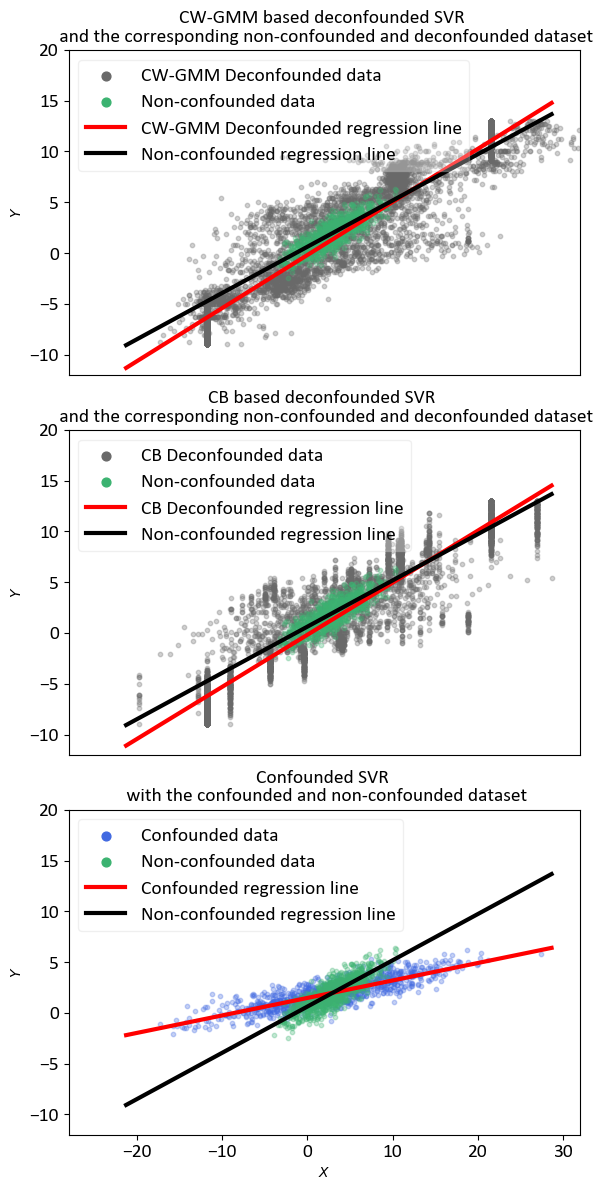

In [19]:
x_grid = np.linspace(np.min([np.min(X_train_conf), np.min(X_test_unconf)]),
                     np.max([np.max(X_train_conf), np.max(X_test_unconf)]), 
                     num=1000)
regLine_conf = conf_regressor.predict(x_grid.reshape(-1,1))
regLine_unconf = unconf_regressor.predict(x_grid.reshape(-1,1))
regLine_deconf_gmm = deconf_gmm_regressor.predict(x_grid.reshape(-1,1))
regLine_deconf_cb = deconf_cb_regressor.predict(x_grid.reshape(-1,1))

fig, axes = plt.subplots(3, 1, figsize=(6, 12))
axes_flatten = axes.ravel()
# Plot deconfounded linear regression line on CW-GMM deconfounded dataset
ax = axes_flatten[0]
ax.scatter(deconf_cwgmm_X, deconf_cwgmm_Y, s=10, c='dimgrey', alpha=0.3, label="CW-GMM Deconfounded data")
ax.scatter(X_test_unconf, Y_test_unconf, s=10, c='mediumseagreen', alpha=0.3, label="Non-confounded data")
ax.plot(x_grid, regLine_deconf_gmm, color='red', label="CW-GMM Deconfounded regression line", linewidth=3)
ax.plot(x_grid, regLine_unconf, color='black', label='Non-confounded regression line', linewidth=3)
ax.set_ylabel(r"$Y$")
ax.set_xticks([])  
ax.set_ylim(-12, 20)
ax.set_xlim(-28, 32)
ax.set_title("CW-GMM based deconfounded SVR \n and the corresponding non-confounded and deconfounded dataset")
legend = ax.legend(fontsize=14, loc="upper left", markerscale=2, framealpha=0.3)
for handle in legend.legend_handles:
    handle.set_alpha(1.0)

# Plot deconfounded linear regression line on CB deconfounded dataset
ax = axes_flatten[1]
ax.scatter(deconf_cb_X, deconf_cb_Y, s=10, c='dimgrey', alpha=0.3, label="CB Deconfounded data")
ax.scatter(X_test_unconf, Y_test_unconf, s=10, c='mediumseagreen', alpha=0.3, label="Non-confounded data")
ax.plot(x_grid, regLine_deconf_cb, color='red', label="CB Deconfounded regression line", linewidth=3)
ax.plot(x_grid, regLine_unconf, color='black', label='Non-confounded regression line', linewidth=3)
ax.set_ylabel(r"$Y$")
ax.set_xticks([])  
ax.set_ylim(-12, 20)
ax.set_xlim(-28, 32)
ax.set_title("CB based deconfounded SVR \n and the corresponding non-confounded and deconfounded dataset")
legend = ax.legend(fontsize=14, loc="upper left", markerscale=2, framealpha=0.3)
for handle in legend.legend_handles:
    handle.set_alpha(1.0)

# Plot confounded linear regression line on confounded dataset    
ax = axes_flatten[2]
ax.scatter(X_test_conf, Y_test_conf, s=10, c='royalblue', alpha=0.3, label="Confounded data")
ax.scatter(X_test_unconf, Y_test_unconf, s=10, c='mediumseagreen', alpha=0.3, label="Non-confounded data")
ax.plot(x_grid, regLine_conf, color='red', label="Confounded regression line", linewidth=3)
ax.plot(x_grid, regLine_unconf, color='black', label='Non-confounded regression line', linewidth=3)
ax.set_ylabel(r"$Y$")
ax.set_xlabel(r"$X$")
ax.set_ylim(-12, 20)
ax.set_xlim(-28, 32)
ax.set_title("Confounded SVR \n with the confounded and non-confounded dataset")
legend = ax.legend(fontsize=14, loc="upper left", markerscale=2, framealpha=0.3)
for handle in legend.legend_handles:
    handle.set_alpha(1.0)
plt.tight_layout()
plt.show()